In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [2]:
class Maximize(object):
    period = 30
    #np.random.seed(period)

    
    def __init__(self, n, rho, gamma):
        self.n = n
        self.rho = rho
        self.gamma = gamma
        
        
    def MC_data(self):
        self.market_ = stats.norm.rvs(size=(self.n, self.period+1), loc=0, scale=1)
        self.rf_ = stats.norm.rvs(size=(self.n, self.period+1), loc=0, scale=1)
        self.brownian_ = stats.norm.rvs(size=(self.n, self.period+1), loc=0, scale=1)
        self.hc_ = self.rho * self.market_ + np.sqrt(1 - self.rho ** 2) * self.brownian_

        
    def get_original_H(self, hc_mu, hc_sigma):
        dc_rate = np.exp((0.04 + 0.0 + 0.0) * (np.array(range(self.period)) + 1) * (-1))
        
        if self.period == 0:
            self.labor_income = np.zeros([self.n, self.period+1])
            self.H_t = np.zeros([self.n])
        else:
            self.labor_income = self.initial_income*np.cumprod(np.exp(hc_mu+hc_sigma*(self.rho * self.market_[:, :-1] + np.sqrt(1 - self.rho ** 2) * self.hc_[:, :-1])), axis=1)
            self.H_t = self.labor_income @ dc_rate
    
    
    def get_asset_ret(self, market_mu, market_sigma, rf_mu, rf_sigma):
        risky_ret = np.exp(market_mu+(0.5*(market_sigma**2))+market_sigma*self.market_[:, 0])
        rf_ret = np.exp(rf_mu+(0.5*(rf_sigma**2))+rf_sigma*self.rf_[:, 0])
        #rf_ret = np.exp(rf_mu*np.ones(market_[:, 0].shape))
        
        self.R_t =  np.array([risky_ret, rf_ret]).T
    
    
    def fit(self):
        def obj(weight, gamma):
            W_t = (self.initial_wealth+(self.initial_income*0.3))*(self.R_t @ weight)

            if self.gamma == 1:
                obj = np.log(W_t+self.H_t) * (-1)
            else:
                obj = (((W_t+self.H_t) ** (1-self.gamma)) / (1-self.gamma)) * (-1)

            return np.mean(obj)

        x = np.ones([self.R_t.shape[1]]) / self.R_t.shape[1]
        cons = ({'type': 'ineq', 'fun': lambda x: 1 - np.sum(x)},
                {'type': 'ineq', 'fun': lambda x: x},)
        optimized = minimize(obj, x, (self.gamma), method='COBYLA', constraints=cons)
        if not optimized.success: raise BaseException(optimized.message)
        return np.round(optimized.x, 4)
    
        
    def change_parameters(self, period, initial_wealth, initial_income):
        self.period = period
        self.initial_wealth = initial_wealth
        self.initial_income = initial_income

In [3]:
class Maximize_Calibraton(object):
    period = 30
    #np.random.seed(period)
    retirement_age = 60

    
    def __init__(self, n, gamma, aggregate_risk, corr=None, rho=None):
        self.n = n
        self.corr = corr
        self.rho = rho
        self.gamma = gamma
        self.aggregate_risk = aggregate_risk
        
            
    def MC_data(self):
        self.market_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.rf_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.brownian_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.hc_ = self.aggregate_risk*(self.rho * self.market_ + np.sqrt(1 - self.rho ** 2) * self.brownian_)
        
        
    def MC_multi_data(self):
        self.brownian_ = np.random.multivariate_normal(np.zeros([self.corr.shape[0]]), self.corr, size=(self.n, self.period+2))
        self.market_ = self.brownian_[:, 0, 1:]
        self.hc_ = self.aggregate_risk*self.brownian_[:, :, :1].reshape(self.n, self.period+2)


    def get_calibration_H(self, fixed_effect_coeff, age_coeff_list):
        dc_rate = np.exp((0.04 + 0.04 + 0.0) * (np.array(range(self.period+1)) + 1) * (-1))
        age_list = np.array(list(range(self.retirement_age-(self.period+1), self.retirement_age)))

        after_retire_H_t = np.exp(fixed_effect_coeff) / (1-dc_rate[0])
        if self.period == 0:
            self.labor_income = np.exp(fixed_effect_coeff)
            self.H_t = after_retire_H_t
        else:
            ic_list = fixed_effect_coeff + (age_list * age_coeff_list[0]) + ((age_list**2 /10) * age_coeff_list[1]) + ((age_list**3/100) * age_coeff_list[2])
            self.labor_income = np.exp(np.array([ic_list]*self.n)  + self.hc_[:, :-1])
            self.H_t = self.labor_income @ dc_rate + (after_retire_H_t * dc_rate[-1])

    
    def get_asset_ret(self, market_mu, market_sigma, rf_mu, rf_sigma):
        risky_ret = np.exp(market_mu+(0.5*(market_sigma**2))+market_sigma*self.market_[:, 0])
        rf_ret = np.exp(rf_mu+(0.5*(rf_sigma**2))+rf_sigma*self.rf_[:, 0])
        #rf_ret = np.exp(rf_mu*np.ones(market_[:, 0].shape))
        
        self.R_t =  np.array([risky_ret, rf_ret]).T
        
        
    def get_multiasset_ret(self, asset_data, freq_multiplyer=1, mu_adj=False):
        self.asset_mu = asset_data.mean().values * freq_multiplyer
        if mu_adj is True:
            self.asset_mu[:-4] = self.asset_mu[:-4] / 2
        self.asset_std = asset_data.std().values * np.sqrt(freq_multiplyer)
        
        self.R_t = np.exp(np.ones(self.market_.shape)*self.asset_mu + (0.5*(np.ones(self.market_.shape)*self.asset_std)**2) + (self.asset_std*self.market_))
    
    
    def fit(self, weight_constraint=False):
        def obj(weight, gamma):
            W_t = (self.initial_wealth+(self.initial_income*0.3))*(self.R_t @ weight)

            if self.gamma == 1:
                obj = np.log(W_t+self.H_t) * (-1)
            else:
                obj = (((W_t+self.H_t) ** (1-self.gamma)) / (1-self.gamma)) * (-1)

            return np.mean(obj)

        x = np.ones([self.R_t.shape[1]]) / self.R_t.shape[1]
        if weight_constraint is False:
            cons = ({'type': 'ineq', 'fun': lambda x: 1 - np.sum(x)},
                    {'type': 'ineq', 'fun': lambda x: x},)
        else:
            cons = ({'type': 'ineq', 'fun': lambda x: 1 - np.sum(x)},
                    {'type': 'ineq', 'fun': lambda x: x},
                    {'type': 'ineq', 'fun': lambda x: 0.25 - x},)
        
        optimized = minimize(obj, x, (self.gamma), method='COBYLA', constraints=cons, options={"maxiter":2000})
        if not optimized.success: raise BaseException(optimized.message)
        return np.round(optimized.x, 4)
    
        
    def change_parameters(self, period, initial_wealth, initial_income, retirement_age=60):
        self.period = period
        self.initial_wealth = initial_wealth
        self.initial_income = initial_income
        self.retirement_age = retirement_age

In [4]:
def lc_asset_allocation(asset_dic, group_characherize_dic, sample_size=20000, gamma=4):
    np.random.seed(30)

    lc_weights = []
    lc_labor_income = []
    lc_wealth = []
    model = Maximize_Calibraton(n=sample_size, rho=group_characherize_data["rho"], gamma=gamma, aggregate_risk=group_characherize_data["aggregate_risk"])
    for i in range(35)[::-1]:

        if i is range(35)[::-1][0]:
            financial_wealth = group_characherize_data["initial_wealth"]
            income = group_characherize_data["initial_income"]
            model.change_parameters(i, financial_wealth, income)
        else:
            financial_wealth = (model.initial_wealth + np.mean(model.labor_income[:, 0]) * 0.3) * np.mean(model.R_t @ model.fit())
            income = np.mean(model.labor_income[:, 0])
            model.change_parameters(i, financial_wealth, income)

        model.MC_data()
        model.get_calibration_H(fixed_effect_coeff=group_characherize_data["fixed_effect_coeff"], age_coeff_list=group_characherize_data["age_coeff_list"])
        model.get_asset_ret(market_mu=asset_data["risky"][0], market_sigma=asset_data["risky"][1], 
                            rf_mu=asset_data["rf"][0], rf_sigma=asset_data["rf"][1])
        opt_weights = model.fit()

        lc_weights.append(opt_weights)
        lc_labor_income.append(np.round(income))
        lc_wealth.append(np.round(financial_wealth))
        #print(model.period, opt_weights * 100, np.round(financial_wealth), np.round(income))

        #print(model.period, model.fit() * 100, np.round(model.initial_wealth), np.round(np.mean(model.labor_income[:, 0])))

    lc_df = pd.DataFrame(lc_weights, columns=["risky_asset", "risk_free"]) * 100
    lc_total_df = pd.DataFrame(np.array([lc_labor_income, lc_wealth]).T, index=range(35)[::-1], columns=["labor_income", "financial_wealth"])
    
    return lc_df, lc_total_df


def data_plotting(lc_total_df):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)

    ln1 = ax.plot(lc_total_df.index[::-1], lc_total_df.labor_income, color="b", label="labor_income")
    ax2 = ax.twinx()
    ln2 = ax2.plot(lc_total_df.index[::-1], lc_total_df.financial_wealth, color="r", linestyle="--", label="financial_wealth")

    lns = ln1+ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs)

    plt.show()
    

def lc_weights_plot(lc_df):
    lc_df = lc_df.copy().cumsum(axis=1)
    
    plt.figure(figsize=(10, 5))
    
    plt.fill_between(lc_df.index, lc_df[lc_df.columns[0]])
    for i in range(lc_df.columns.shape[0]-1):
        plt.fill_between(lc_df.index, lc_df[lc_df.columns[i]], lc_df[lc_df.columns[i+1]])
    plt.legend(lc_df.columns)
    plt.ylim(0, 100)
    plt.show()

In [5]:
def lc_multiasset_allocation(asset_dic, group_characherize_dic, sample_size=20000, gamma=4, weight_constraint=False, mu_adj=False):
    np.random.seed(30)

    lc_weights = []
    lc_labor_income = []
    lc_wealth = []
    model = Maximize_Calibraton(n=sample_size, corr=group_characherize_data["corr_mat"], gamma=gamma, aggregate_risk=group_characherize_data["aggregate_risk"])
    for i in range(35)[::-1]:

        if i is range(35)[::-1][0]:
            financial_wealth = group_characherize_data["initial_wealth"]
            income = group_characherize_data["initial_income"]
            model.change_parameters(i, financial_wealth, income)
        else:
            financial_wealth = (model.initial_wealth + np.mean(model.labor_income[:, 0]) * 0.3) * np.mean(model.R_t @ model.fit())
            income = np.mean(model.labor_income[:, 0])
            model.change_parameters(i, financial_wealth, income)

        model.MC_multi_data()
        model.get_calibration_H(fixed_effect_coeff=group_characherize_data["fixed_effect_coeff"], age_coeff_list=group_characherize_data["age_coeff_list"])
        model.get_multiasset_ret(asset_dic, freq_multiplyer=252, mu_adj=False)
        opt_weights = model.fit(weight_constraint=weight_constraint)

        lc_weights.append(opt_weights)
        lc_labor_income.append(np.round(income))
        lc_wealth.append(np.round(financial_wealth))
        #print(model.period, opt_weights * 100, np.round(financial_wealth), np.round(income))

        #print(model.period, model.fit() * 100, np.round(model.initial_wealth), np.round(np.mean(model.labor_income[:, 0])))

    lc_df = pd.DataFrame(lc_weights, columns=asset_dic.columns) * 100
    lc_total_df = pd.DataFrame(np.array([lc_labor_income, lc_wealth]).T, index=range(35)[::-1], columns=["labor_income", "financial_wealth"])
    
    return lc_df, lc_total_df

In [6]:
asset_data = {"risky": [0.12, 0.35], "rf":[0.04, 0.03]}

## High_school edu levels
_______________

In [7]:
group_characherize_data = {"rho":0.633465, "aggregate_risk":np.sqrt(0.174855+0.005461), 
                           "fixed_effect_coeff":[7.5072-0.7417+0.3198+0.059*2], "age_coeff_list":[0.0124, 0.0064, -0.0009], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.5072-0.7417+0.3198+0.059*2 + (25 * 0.0124 + ((25**2 /10) *0.0064) + ((25**3/100) * -0.0009)))}

In [8]:
lc_weights, lc_data = lc_asset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=6)

In [9]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2375.0,2595.0,2664.0,2752.0,2834.0,2889.0,2984.0,3066.0,3148.0,3223.0,...,4361.0,4408.0,4446.0,4444.0,4486.0,4496.0,4530.0,4509.0,4497.0,4508.0
financial_wealth,1000.0,2265.0,3900.0,6031.0,8785.0,12259.0,16520.0,21231.0,26542.0,32341.0,...,284528.0,317347.0,354368.0,394439.0,439198.0,488685.0,543521.0,603644.0,669397.0,745511.0


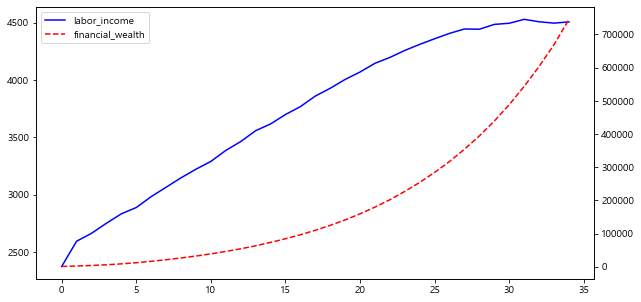

In [10]:
data_plotting(lc_data)

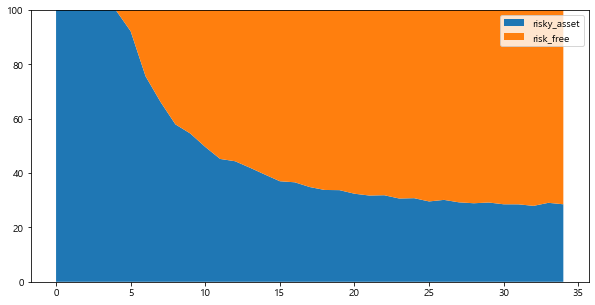

In [11]:
lc_weights_plot(lc_weights)

## College edu levels
_______________

In [12]:
group_characherize_data = {"rho":0.334903, "aggregate_risk":np.sqrt(0.145682+0.010166), 
                           "fixed_effect_coeff":[7.8016-2.3326+0.2550+0.0537*2], "age_coeff_list":[0.1232, -0.0193, 0.0011], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.8016-2.3326+0.2550+0.0537*2 + (25 * 0.1232 + ((25**2 /10) * -0.0193) + ((25**3/100) * 0.0011)))}

In [13]:
lc_weights, lc_data = lc_asset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=4)

In [14]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2636.0,2845.0,2977.0,3126.0,3267.0,3377.0,3527.0,3659.0,3787.0,3908.0,...,5473.0,5555.0,5624.0,5657.0,5729.0,5800.0,5888.0,5930.0,5978.0,6065.0
financial_wealth,1000.0,2361.0,4141.0,6482.0,9526.0,13386.0,18403.0,24845.0,33151.0,43154.0,...,632345.0,723649.0,829911.0,948090.0,1084253.0,1239005.0,1416132.0,1615683.0,1840453.0,2109999.0


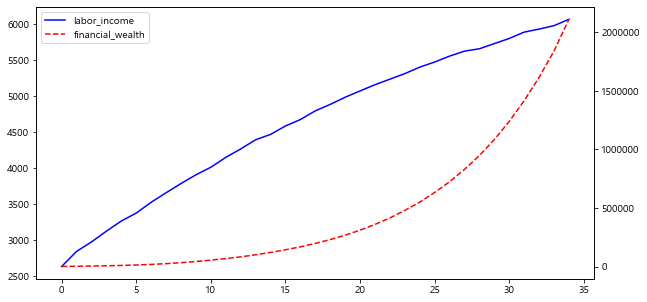

In [15]:
data_plotting(lc_data)

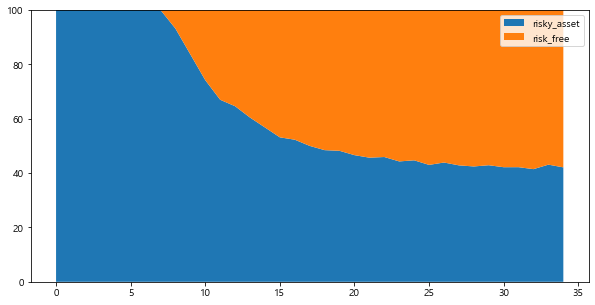

In [16]:
lc_weights_plot(lc_weights)

## University edu levels
_______________

In [17]:
group_characherize_data = {"rho":-0.010961, "aggregate_risk":np.sqrt(0.141262+0.005379), 
                           "fixed_effect_coeff":[7.8717-2.3055+0.3841+0.0440*2], "age_coeff_list":[0.1055, -0.0111, 0.0001], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.8717-2.3055+0.3841+0.0440*2 + (25 * 0.1055 + ((25**2 /10) * -0.0111) + ((25**3/100) * 0.0001)))}

In [18]:
lc_weights, lc_data = lc_asset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=4)

In [19]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2974.0,3195.0,3358.0,3541.0,3719.0,3866.0,4054.0,4225.0,4390.0,4550.0,...,6212.0,6249.0,6250.0,6216.0,6191.0,6177.0,6154.0,6091.0,6008.0,5950.0
financial_wealth,1000.0,2494.0,4457.0,7044.0,10417.0,14705.0,20284.0,27458.0,36716.0,48413.0,...,736188.0,842566.0,966366.0,1104070.0,1262601.0,1442814.0,1649110.0,1881403.0,2143077.0,2457028.0


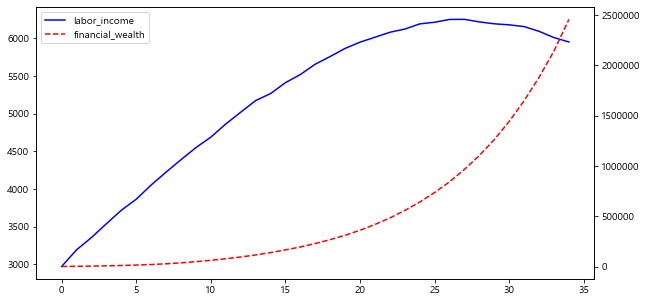

In [20]:
data_plotting(lc_data)

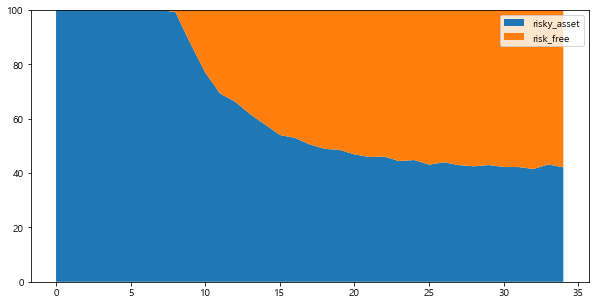

In [21]:
lc_weights_plot(lc_weights)

## University edu levels with Multi-asset (rho=4)
_______________

In [22]:
asset_data = pd.read_excel("C:\\Users\\JeayongYu\\PycharmProjects\\human_captial\\data\\korea_industry_return_daily.xlsx", index_col=0) / 100
corr_mat = pd.read_excel("C:\\Users\\JeayongYu\\PycharmProjects\\human_captial\\data\\university_corr.xlsx", index_col=0)

In [23]:
group_characherize_data = {"corr_mat":corr_mat.values, "aggregate_risk":np.sqrt(0.141262+0.005379), 
                           "fixed_effect_coeff":[7.8717-2.3055+0.3841+0.0440*2], "age_coeff_list":[0.1055, -0.0111, 0.0001], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.8717-2.3055+0.3841+0.0440*2 + (25 * 0.1055 + ((25**2 /10) * -0.0111) + ((25**3/100) * 0.0001)))}

In [24]:
lc_weights, lc_data = lc_multiasset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=4)

In [25]:
lc_weights = lc_weights[(lc_weights != 0)].dropna(axis=1, how="all").fillna(0)

In [26]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2974.0,3198.0,3354.0,3543.0,3705.0,3860.0,4054.0,4204.0,4386.0,4528.0,...,6225.0,6251.0,6200.0,6238.0,6217.0,6201.0,6124.0,6099.0,5998.0,5934.0
financial_wealth,1000.0,2585.0,4732.0,7673.0,11576.0,16705.0,23443.0,32113.0,43593.0,58374.0,...,3538854.0,4542546.0,5817229.0,7438140.0,9533300.0,12207619.0,15610252.0,20044836.0,25551134.0,32807069.0


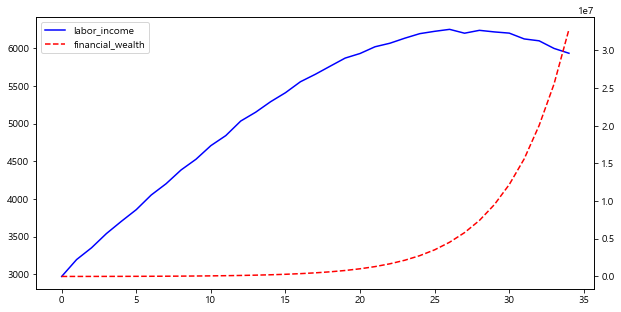

In [27]:
data_plotting(lc_data)

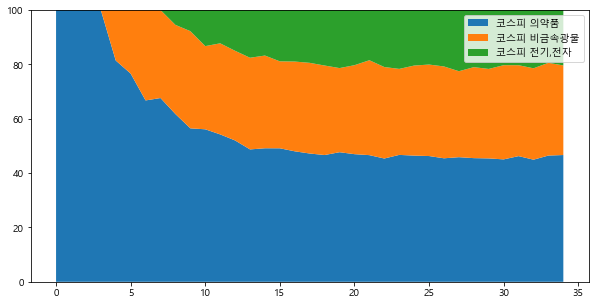

In [28]:
lc_weights_plot(lc_weights)

## University edu levels with Multi-asset (rho=6)
_______________

In [29]:
group_characherize_data = {"corr_mat":corr_mat.values, "aggregate_risk":np.sqrt(0.141262+0.005379), 
                           "fixed_effect_coeff":[7.8717-2.3055+0.3841+0.0440*2], "age_coeff_list":[0.1055, -0.0111, 0.0001], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.8717-2.3055+0.3841+0.0440*2 + (25 * 0.1055 + ((25**2 /10) * -0.0111) + ((25**3/100) * 0.0001)))}

In [30]:
lc_weights, lc_data = lc_multiasset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=6)

In [31]:
lc_weights = lc_weights[(lc_weights != 0)].dropna(axis=1, how="all").fillna(0)

In [32]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2974.0,3198.0,3354.0,3543.0,3705.0,3860.0,4054.0,4204.0,4386.0,4528.0,...,6225.0,6251.0,6200.0,6238.0,6217.0,6201.0,6124.0,6099.0,5998.0,5934.0
financial_wealth,1000.0,2585.0,4732.0,7649.0,11442.0,16435.0,22970.0,31339.0,42205.0,56107.0,...,3088221.0,3917312.0,4950346.0,6241224.0,7865398.0,9944771.0,12505627.0,15800051.0,19782117.0,25159094.0


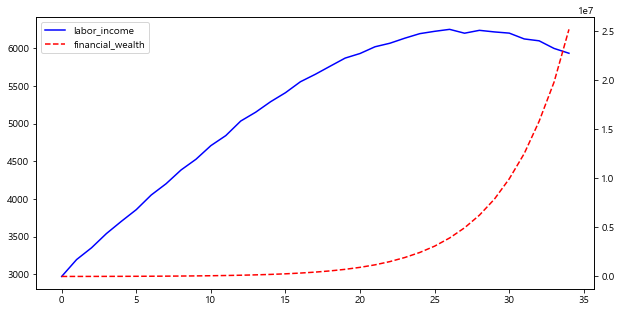

In [33]:
data_plotting(lc_data)

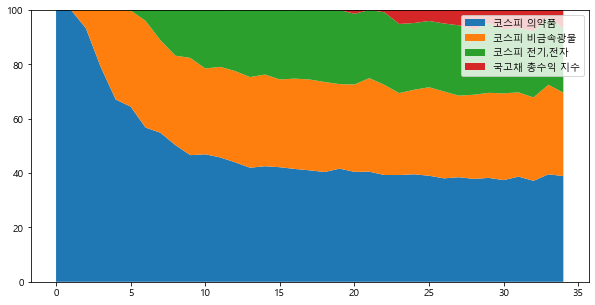

In [34]:
lc_weights_plot(lc_weights)

## University edu levels with Multi-asset (rho=4, weight_cap=0.25)
_______________

In [35]:
lc_weights, lc_data = lc_multiasset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=6, weight_constraint=True)
lc_weights = lc_weights[(lc_weights != 0)].dropna(axis=1, how="all").fillna(0)

lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2974.0,3198.0,3354.0,3543.0,3705.0,3860.0,4054.0,4204.0,4386.0,4528.0,...,6225.0,6251.0,6200.0,6238.0,6217.0,6201.0,6124.0,6099.0,5998.0,5934.0
financial_wealth,1000.0,2585.0,4732.0,7649.0,11442.0,16435.0,22970.0,31339.0,42205.0,56107.0,...,3088221.0,3917312.0,4950346.0,6241224.0,7865398.0,9944771.0,12505627.0,15800051.0,19782117.0,25159094.0


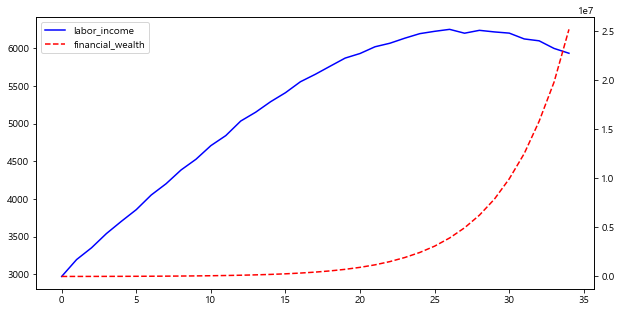

In [36]:
data_plotting(lc_data)

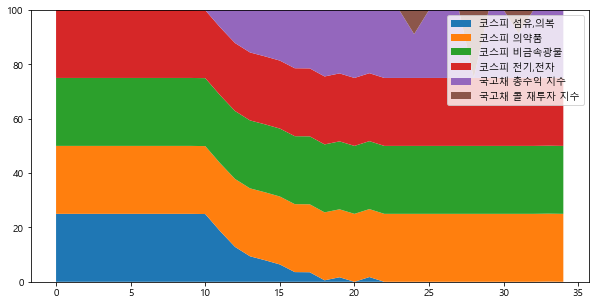

In [37]:
lc_weights_plot(lc_weights)

## University edu levels with Ajdusted return Multi-asset (rho=4)
_______________

In [38]:
lc_weights, lc_data = lc_multiasset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=4)
lc_weights = lc_weights[(lc_weights != 0)].dropna(axis=1, how="all").fillna(0)

lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2974.0,3198.0,3354.0,3543.0,3705.0,3860.0,4054.0,4204.0,4386.0,4528.0,...,6225.0,6251.0,6200.0,6238.0,6217.0,6201.0,6124.0,6099.0,5998.0,5934.0
financial_wealth,1000.0,2585.0,4732.0,7673.0,11576.0,16705.0,23443.0,32113.0,43593.0,58374.0,...,3538854.0,4542546.0,5817229.0,7438140.0,9533300.0,12207619.0,15610252.0,20044836.0,25551134.0,32807069.0


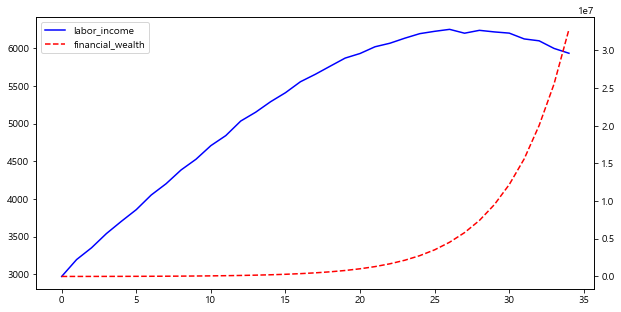

In [39]:
data_plotting(lc_data)

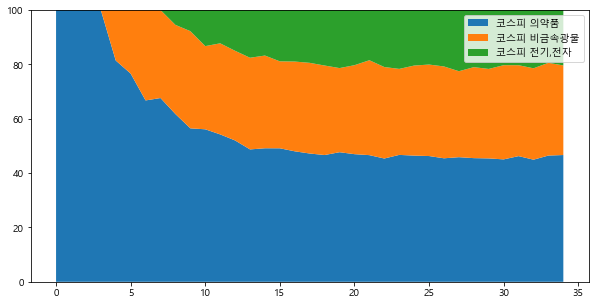

In [40]:
lc_weights_plot(lc_weights)

## University edu levels with Ajdusted return Multi-asset (rho=4, weight_cap=0.25)
_______________

In [41]:
lc_weights, lc_data = lc_multiasset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=4, weight_constraint=True, mu_adj=True)
lc_weights = lc_weights[(lc_weights != 0)].dropna(axis=1, how="all").fillna(0)

lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2974.0,3198.0,3354.0,3543.0,3705.0,3860.0,4054.0,4204.0,4386.0,4528.0,...,6225.0,6251.0,6200.0,6238.0,6217.0,6201.0,6124.0,6099.0,5998.0,5934.0
financial_wealth,1000.0,2585.0,4732.0,7673.0,11576.0,16705.0,23443.0,32113.0,43593.0,58374.0,...,3538854.0,4542546.0,5817229.0,7438140.0,9533300.0,12207619.0,15610252.0,20044836.0,25551134.0,32807069.0


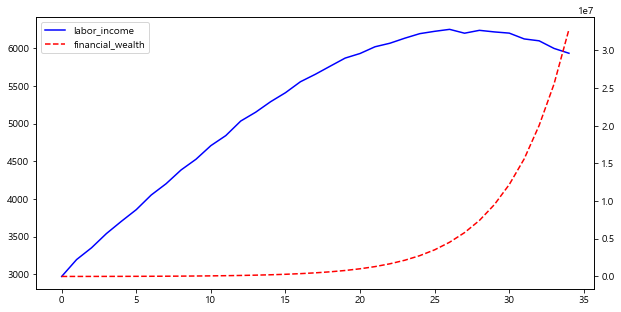

In [42]:
data_plotting(lc_data)

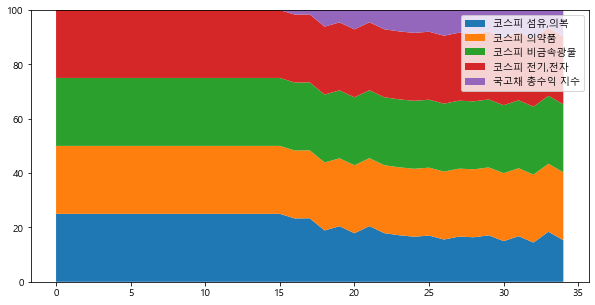

In [43]:
lc_weights_plot(lc_weights)